# 0 TCLab Overview

The following cells in this notebook demonstrate the use of the Temperature Control Lab.

## TCLab Architecture
<img src='images/TCLabOverview.png' style="float: left;padding-right:30px;"></img>
**_Jupyter notebooks:_**
Examples, lessons, and student projects.

**_TCLab:_**
Provide high-level ccess to sensors, heaters, a pseudo-realtime clock.

**_sketch.ino:_**
Firmware for the intrisically safe operation of the Arduino board and shield.

**_Arduino:_**
Hardware platform for the Temperature Control Laboratory.

## Connecting to the Temperature Control Laboratory

### Importing tclab

Using TCLab is straightforward. The first step is to import `TCLab` from the python module named `tclab`.  The following cell shows how this can be done if the module is located in a user directory. In this case, the argument ot `sys.path.append` should point to the directory where that module is located. If TCLab has been installed with a package manager then the first two lines may be unnecessary.

In [2]:
import sys
sys.path.append("..")
from tclab import TCLab

### Creating and Closing a Connection

A tclab() instance is created with the statement

    a = TCLab()

Upon creation, the tclab() instance attempts to find a device connected to a serial port. An error is generated if no device is found.  The instance should be closed when no longer in use.

In [3]:
import sys
sys.path.append("..")
from tclab import TCLab

a = TCLab()
print(a.version)
a.close()

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410
TCLab Firmware Version 1.1.0
TCLab disconnected successfully.


### Using tclab with Python's `with` statement

The Python `with` statement provides a convenient means of setting up and closing a connection to the Temperature Control Laboratory. In particular, the with statement establishes a context where a tclab instance is created, assigned to a variable, and automatically closed when finished.  The `with` statement is likely to be the most common way to connect the Temperature Control Laboratory for most uses.

In [4]:
from tclab import TCLab

with TCLab() as a:
    print(a.version)

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410
TCLab Firmware Version 1.1.0
TCLab disconnected successfully.


## Reading Temperatures

Once a tclab instance is created and connected to a device, the temperature sensors on the temperature control lab can be acccessed with the attributes `.T1` and `.T2`.  For example, given an instance `a`, the temperatures are accessed as

    T1 = a.T1
    T2 = a.T2

Note that `a.T1` and `a.T2` are read-only properties. Any attempt to set them to a value will return a Python error.

In [5]:
from tclab import TCLab

with TCLab() as a:
    print("Temperature 1: {0:0.2f} C".format(a.T1))
    print("Temperature 2: {0:0.2f} C".format(a.T2))

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410
Temperature 1: 19.61 C
Temperature 2: 19.93 C
TCLab disconnected successfully.


## Setting Heaters

The heaters are controlled by functions`.Q1()` and `.Q2()` of a tclab instance. For example, both heaters can be set to 100% power with the functions

    a.Q1(100)
    a.Q2(100)

The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via

    Q1 = a.Q1()
    Q2 = a.Q2()
    
Note that the retrieved values may be different due to the range-limiting enforced by the device firmware.

In [6]:
from tclab import TCLab
import time

with TCLab() as a:
    print("\nStarting Temperature 1: {0:0.2f} C".format(a.T1),flush=True)
    print("Starting Temperature 2: {0:0.2f} C".format(a.T2),flush=True)

    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    t_heat = 30
    print("\nHeat for", t_heat, "seconds")
    time.sleep(t_heat)

    print("\nTurn Heaters Off")
    a.Q1(0)
    a.Q2(0)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    print("\nFinal Temperature 1: {0:0.2f} C".format(a.T1))
    print("Final Temperature 2: {0:0.2f} C".format(a.T2))

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410

Starting Temperature 1: 19.61 C
Starting Temperature 2: 19.61 C

Set Heater 1: 100.0 %
Set Heater 2: 100.0 %

Heat for 30 seconds

Turn Heaters Off

Set Heater 1: 0.0 %
Set Heater 2: 0.0 %

Final Temperature 1: 19.61 C
Final Temperature 2: 19.93 C
TCLab disconnected successfully.


## Syncronizing with Real Time using `clock`

For convenience, the tclab module includes a function `clock` for synchronizing calculations with real time.  `clock(tperiod, tstep)` is a python iterator that generates a sequence of iterations over a period of `tperiod` seconds separated by `tstep` seconds. 

In [7]:
from tclab import TCLab, clock

tperiod = 5
tstep = 1
for t in clock(tperiod,tstep):
    print(t, "sec.")

0.0 sec.
1.0 sec.
2.0 sec.
3.0 sec.
4.0 sec.
5.0 sec.


There are some considerations to keep in mind when using `clock`. Most important, by its nature Python is not a real-time environment. `clock` makes a best effort to stay in sync with the wall clock, but there is no guarantee.

Second, whatever calculations you perform inside the clock must take less than tstep seconds to complete, otherwise there is no way for `clock` to keep up with real time. Under normal usage, an error exception is raised if `clock` fails to keep up with real time.

There is an optional flag that allows clock to slip out of real time sync. The usage is

    clock(tfinal, tstep, strict=False)
    
which is demonstrated in the following cell where, for a certain interval, a calculation is performed that takes longer than tstep to complete.

In [8]:
from tclab import TCLab, clock

import time

tfinal = 12
tstep = 2
for t in clock(tfinal,tstep,strict=False):
    print(t, "sec.")
    if (t > 3) and (t < 5):
        time.sleep(2.2)

0.0 sec.
2.0 sec.
4.0 sec.
6.2 sec.
8.2 sec.
10.2 sec.


## Realtime Plotting

Real time plotting is available within Jupyter notebooks. The command

    a.initplot(tfinal)
    
initializes plotting with the horizontal axis set from 0 to `tfinal`. Subsequent commands

    a.updateplot()

extend the plots of all four attributes `.T1`, `.T2`, `.Q1` and `.Q2`. This would commonly be include in a `clock(tfinal)` loop to create real-time plots.

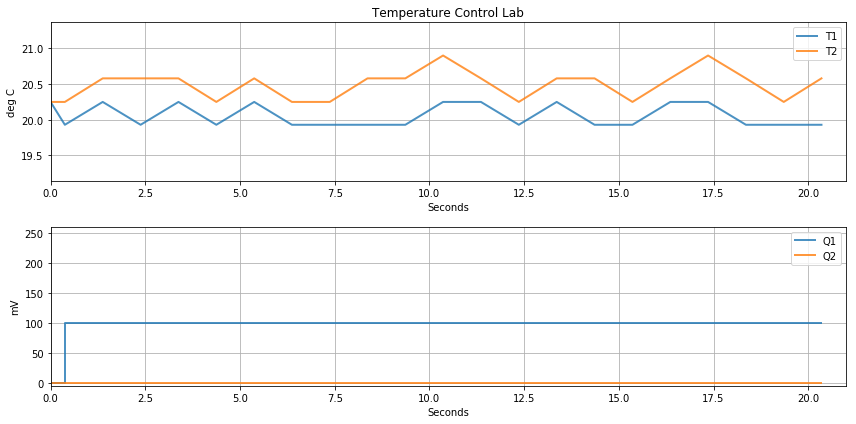

TCLab disconnected successfully.


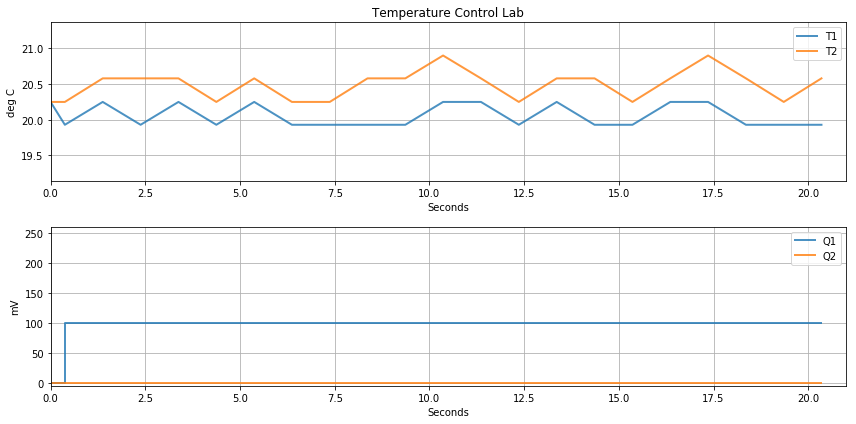

In [1]:
%matplotlib inline 
import sys
sys.path.append("..")
from tclab import TCLab, clock

tperiod = 20

with TCLab() as a:
    a.initplot(tperiod)
    for t in clock(tperiod):
        a.Q1(100 if t < 100 else 0)
        a.updateplot()

## Logging Data

Values of the `.T1`, `.T2`, `.Q1`, and `.Q2` attributes are logged whenever they are accessed. If `a` is a TCLab instance, the log may be plotted with the command

    a.plot()
    
as demonsstrated in the following cells.

In [2]:
%matplotlib inline
import sys
sys.path.append("..")
from tclab import TCLab, clock
from tclab import Historian

# connect to the temperature control lab
with TCLab() as a:
    # turn heaters on
    a.Q1 = 200
    a.Q2 = 100
    h = Historian()
    print("\nSet Heater 1 to {0:d} mV".format(a.Q1))
    print("Set Heater 2 to {0:d} mV".format(a.Q2))

    # report temperatures for the next minutes
    sfmt = "   {0:5.1f} sec:   T1 = {1:0.1f} C    T2 = {2:0.1f} C"
    for t in clock(5,1):
        print(sfmt.format(t, a.T1, a.T2), flush=True)
        h.log([a.Q1,a.Q2,a.T1,a.T2])

Connecting to TCLab
TCLab connected on port /dev/cu.wchusbserial1410

Set Heater 1 to 200 mV
Set Heater 2 to 100 mV
     0.0 sec:   T1 = 19.9 C    T2 = 20.6 C
     1.0 sec:   T1 = 19.9 C    T2 = 20.6 C
     2.0 sec:   T1 = 20.2 C    T2 = 20.6 C
     3.0 sec:   T1 = 19.9 C    T2 = 20.6 C
     4.0 sec:   T1 = 20.2 C    T2 = 20.6 C
     5.0 sec:   T1 = 20.2 C    T2 = 20.6 C
TCLab disconnected successfully.


In [3]:
h._log

[[200, 100, 19.93, 20.58],
 [200, 100, 20.25, 20.58],
 [200, 100, 20.25, 20.58],
 [200, 100, 20.25, 20.58],
 [200, 100, 19.93, 20.25],
 [200, 100, 20.25, 20.58]]